# **PROJECT: BRAIN MODELLING**

In [29]:
import time
import random
import numpy as np
import pickle as pk
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from IPython.display import Image, display 

## **PREPROCESSING**

### **Configuration and Initial Setup**

Sets up the main variables, such as the image size ($img\_size$), and prepares optional tools for performance monitoring, like the timer

In [30]:
img_size = 20 # sets the image pixels eg. 30,30
thr = 30 # Spiking threshold
time_span = 1000  # Simulation time
num_images = 10000
start = time.time()

### **Image Loading and Preprocessing**

Loads the MNIST dataset, selects a random image, and applies preprocessing operations (channel expansion, resizing, normalization, and flattening) to make it compatible with further processing.

In [31]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Merge the training and test images
all_labels = np.concatenate((train_labels, test_labels), axis=0)
all_images = np.concatenate((train_images, test_images), axis=0)

idx = random.randint(0,len(train_images-1))
img = train_images[idx]

In [32]:
# Check the shape of the merged variables
print(f"Shape of all_images: {all_images.shape}")
print(f"Shape of all_labels: {all_labels.shape}")
num_classes = np.unique(all_labels)
num_classes

Shape of all_images: (70000, 28, 28)
Shape of all_labels: (70000,)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### **Support Variable Creation**

Performs calculations to define auxiliary variables, that is, the total size of the vector ($N$), representing all the neurons, and its subdivisions into element groups ($Ni\_size$ and $Ne\_size$), the excitatory and inhibitory neurons.

In [33]:
def split_neurons(current):
    N = current.size  # Total number of pixels
    Ne_size = N * 3 // 4  # 75% excitatory neurons
    Ni_size = N - Ne_size  # 25% inhibitory neurons

    # Split the image data into excitatory and inhibitory components
    Ne = current[:Ne_size]
    Ni = current[Ne_size:]

    return Ne, Ni, Ne_size, Ni_size

### **Preprocessed Image Visualization**

 Transforms the 1D vector of the preprocessed image into a 2D matrix, configures the visualization to remove axes and labels, and displays the image in grayscale.

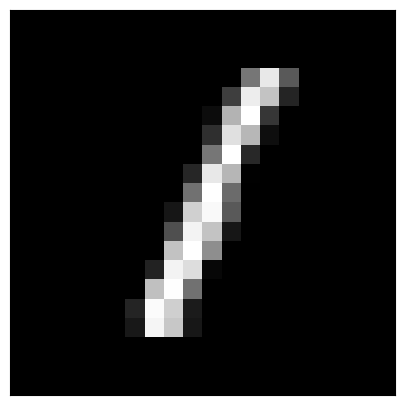

In [34]:
def preprocess(img):
    # Preprocess the image
    img = tf.expand_dims(img, axis=-1)  # Add channel dimension (grayscale)
    img = tf.image.resize(img, (img_size, img_size))  # Resize the image
    img = img / 255.0  # Normalize the image
    current = img.numpy().flatten()  # Flatten the image into a 1D array
    return current

current = preprocess(img)
reshaped_img = current.reshape(img_size, img_size)
plt.figure(figsize=(5, 5))
plt.imshow(reshaped_img, cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.show()

In [35]:
print(current)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.46196085 0.90572554 0.35356915 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0012549  0.24345106 0.92470586 0.7620395  0.14337298 0.
 0.         0.         0.         0.         0.         

## **INITIAL CONFIGURATION**

This section defines the fundamental parameters of the network and initializes values for the simulation.

The key model parameters are:

*  $a, b, c, d:$ represent the intrinsic properties of the neurons, including recovery speed and behavior after a spike.
*   $S:$ the synaptic connection matrix, which includes positive values for excitatory connections and negative values for inhibitory ones.
*   $v:$ the initial membrane potential, set to $v=−65$ for all neurons.
*   $u:$ the recovery variable initialized as $u=b⋅v$.





In [36]:
def initialize_neurons(img_size, current):
    Ne, Ni, Ne_size, Ni_size = split_neurons(current)

    # Generate random variables for neurons' parameters
    re = np.random.rand(Ne_size, 1)  
    ri = np.random.rand(Ni_size, 1) 
    
    # Define neurons' parameters (a, b, c, d) based on neuron types
    a = np.concatenate((0.02 * np.ones((Ne_size, 1)), 0.02 + 0.08 * ri))
    b = np.concatenate((0.2 * np.ones((Ne_size, 1)), 0.25 - 0.05 * ri))
    c = np.concatenate((-65 + 15 * re**2, -65 * np.ones((Ni_size, 1))))
    d = np.concatenate((8 - 6 * re**2, 2 * np.ones((Ni_size, 1))))

    # Construct the synaptic connectivity matrix
    S = np.concatenate(
        (0.5 * np.random.rand(Ne_size + Ni_size, Ne_size),
         -np.random.rand(Ne_size + Ni_size, Ni_size)), axis=1)

    return Ne, Ni, a, b, c, d, S, Ne_size, Ni_size

## **MODEL**

This section simulates the temporal evolution of the network, modeling the interactions and activations of excitatory ($N_e$) and inhibitory ($N_i$) neurons over a defined time span.

At each time step, the following operations are carried out:

**1. Input Calculation:**

*   The total input current ($I$) to each neuron is determined. This input combines external stimuli derived from the preprocessed image data and internal contributions from synaptic connections, represented by the matrix $S$.

**2. Neuron Activation Detection:**

*   Neurons whose membrane potential exceeds the firing threshold ($v≥thr$) are identified.
*   The firing times of the neurons and the indices of the fired ones are saved for later analysis.
*   Upon firing, the membrane potential ($v$) and recovery variable ($u$) of these neurons are reset according to:

$$
v_{fired} = c \; , \quad
u_{fired} = u + d
$$


**3. State Update:**

*   The evolution of the membrane potential ($v$) and the recovery variable ($u$) for all neurons is governed by the following differential equations:

$$\frac{dv}{dt}=0.04v^2+5v+140-u+I\\
\frac{du}{dt}=a(bv-u)$$

*   In this implementation, a discrete time step ($dt=0.5$) is used to approximate these updates iteratively.

In [37]:
# Preprocess images
current = preprocess(img)

N = current.size
# Initialize neuron parameters (excitatory and inhibitory)
Ne, Ni, a, b, c, d, S, Ne_size, Ni_size = initialize_neurons(img_size, current)

# Initialize membrane potentials and recovery variables
v = -65 * np.ones((Ne_size + Ni_size, 1))  # Membrane potentials
u = b * v                                  # Recovery variables

# Initialize array to store spike times
spike_times = np.empty((0, 2), dtype=int)

for t in range(time_span):
    # thalamic input
    I = np.concatenate((5 * current[:Ne_size].reshape(-1,1), 2 * current[Ne_size:].reshape(-1,1)),0)
    fired = np.where(v>=thr)[0]
    if fired is not None:
        firing = np.concatenate((t*np.ones((len(fired),1)),fired.reshape(-1,1)),1)
        spike_times = np.concatenate((spike_times,firing))

        #updating v and u
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        # add the contribution of the neurons that are spiking
        I += S[:,fired].sum(1).reshape(-1,1)

    v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I) # dt = 0.5
    v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I) # dt = 0.5
    u = u + a*(b*v - u)


## **OUTPUT**

Simulation time: 0.0 min 0.19 sec 



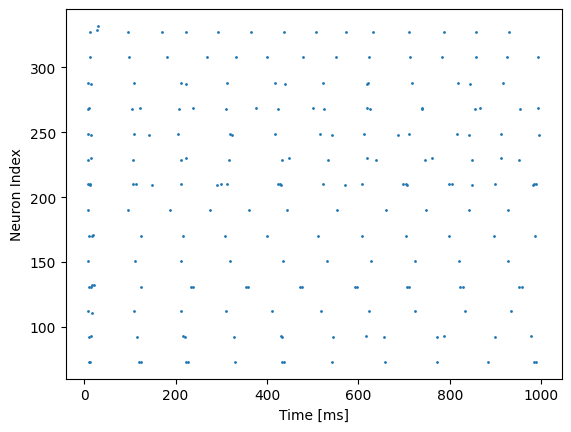

In [38]:
mins = (time.time()-start)//60
sec = (time.time()-start) % 60
print('Simulation time: {} min {:.2f} sec \n'.format(mins, sec))
plt.scatter(spike_times[:,0],spike_times[:,1],s=1)
plt.xlabel('Time [ms]')
plt.ylabel('Neuron Index')
plt.show()

(0.0, 1000.0)

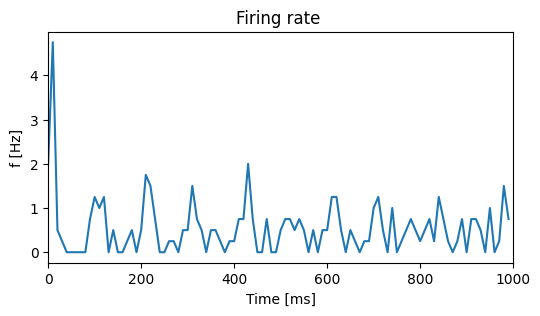

In [39]:
bin_size = 10
bins = np.arange(0, time_span + bin_size, bin_size)
spike_counts, _ = np.histogram(spike_times[:,0], bins)
num_neurons = N
firing_rate_timeseries = spike_counts / (bin_size / time_span * num_neurons)
plt.figure(figsize=(6, 3))
plt.title('Firing rate ')
plt.plot(bins[:-1], firing_rate_timeseries, label='Firing Rate')
plt.xlabel('Time [ms]')
plt.ylabel('f [Hz]')
plt.xlim(0,1000)

## **PATTERNS ANALYSIS**

Analysis was performed on 30 x 30 image input

### **Light in the Upper Portion**

The presence of the horizontal line causes the neurons with index around 400 to exhibit bursting behaviour and generally higher activity

In [40]:
!wget https://github.com/Emirhankayar/img_izh_results/raw/master/Images.zip -O Images.zip
!unzip -o Images.zip
!rm Images.zip



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://github.com/Emirhankaya]87Images.zip             0% [<=>                           ]       0          B/s87HTTP response 302  [https://github.com/Emirhankayar/img_izh_results/raw/master/Images.zip]
87Images.zip             0% [ <=>                          ]       0          B/s87Adding URL: https://raw.githubusercontent.com/Emirhankayar/img_izh_results/master/Images.zip
87[Files: 0  Bytes: 0  [0 B/s] Re]87[https://raw.githubusercontent.]87Saving 'Images.zip'
87Images.zip           100% [=============================>]  283.89K    --.-KB/s87HTTP response 200  [https://raw.githubusercontent.com/Emirhankayar/img_izh_results/master/Images.zip]
87Images.zip           100% [=============================>]  283.89K    --.-KB/s87[Files: 1  Bytes: 283.89K [372.]8Archive:  Images.zip
  inflating: Images/01_uplight/output.png  
  inflating: Images/01_uplight/output1.png  
  inflating: Images/01_uplight/output2.png  
  inflati

In [41]:
img_dir = "Images"

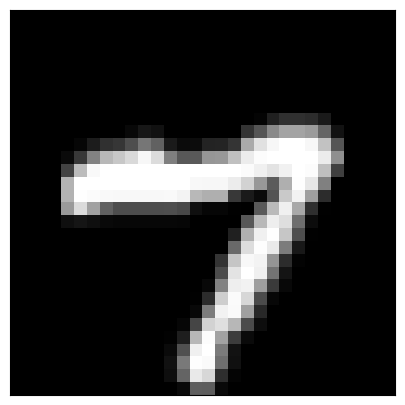

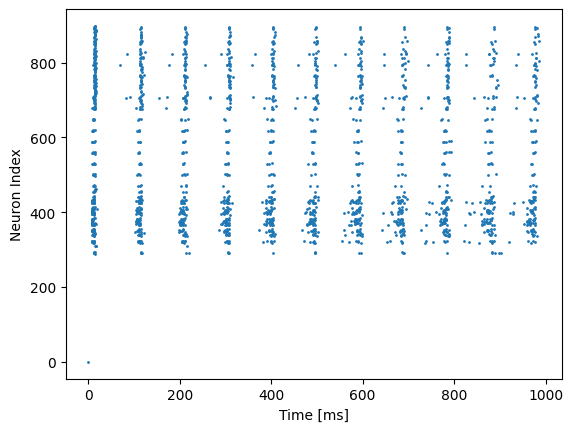

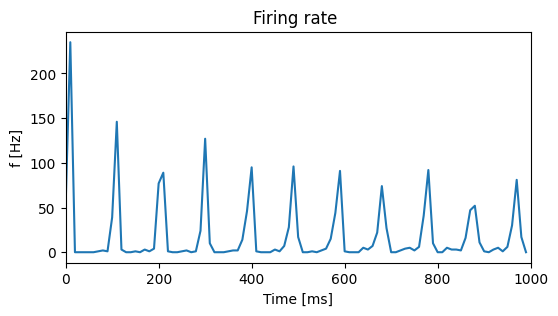

In [42]:
image_paths = [f"{img_dir}/01_uplight/output.png", 
               f"{img_dir}/01_uplight/output1.png", 
               f"{img_dir}/01_uplight/output2.png"]

for image_path in image_paths:
    display(Image(filename=image_path))

### **Light in the Lower Portion**

There we can observe the same phenomenon as above: note that, as the pixel intensity is shifted to the **lower portion** of the image, neurons with **higher index** display that particular behaviour

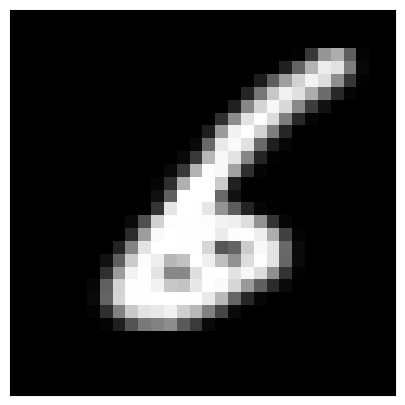

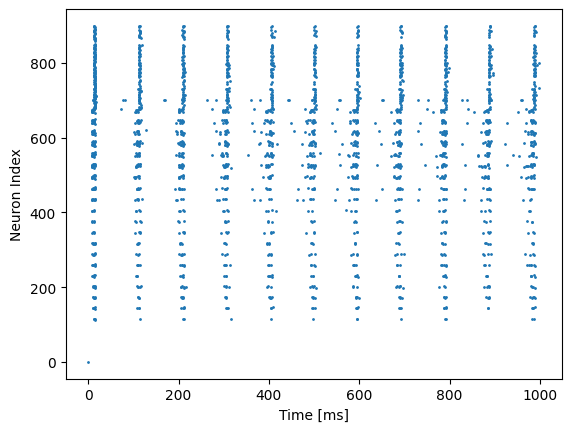

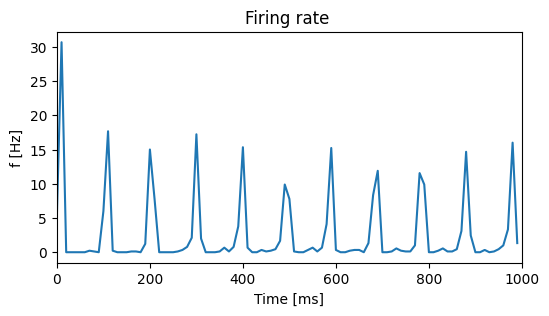

In [43]:
image_paths = [f"{img_dir}/02_downlight/output.png", 
               f"{img_dir}/02_downlight/output1.png", 
               f"{img_dir}/02_downlight/output2.png"]

for image_path in image_paths:
    display(Image(filename=image_path))

### **Light Vertically Distributed**

Bright pixels distributed along the same x coordinate cause clusters of neurons to fire together with almost no evident difference in activity

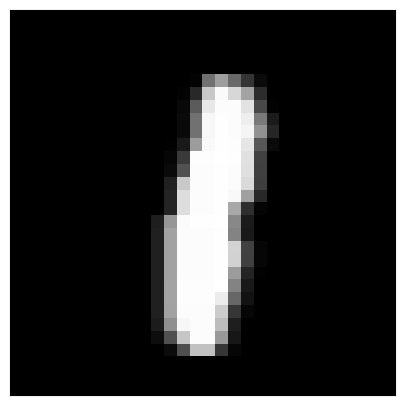

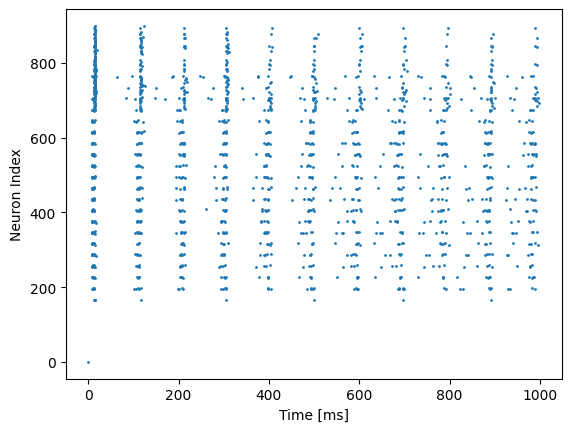

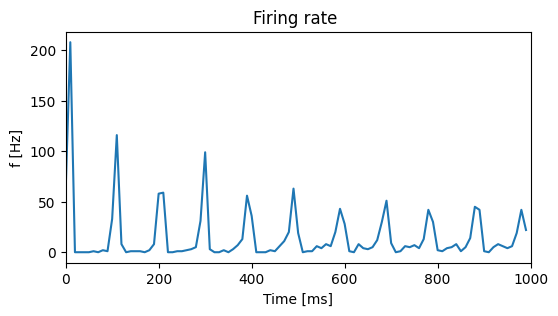

In [44]:
image_paths = [f"{img_dir}/06_verticallight/output.png", 
               f"{img_dir}/06_verticallight/output1.png", 
               f"{img_dir}/06_verticallight/output2.png"]

for image_path in image_paths:
    display(Image(filename=image_path))

### **Low Intensity**

Inputs whose intensity is not high enough are not able to give raise to meaningful neuronal activity

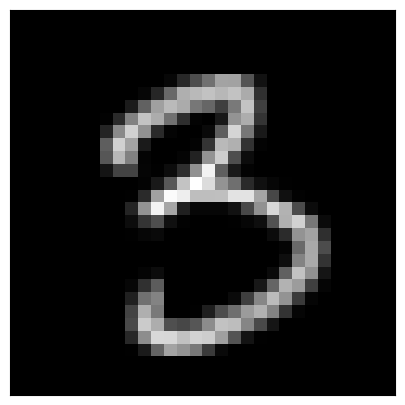

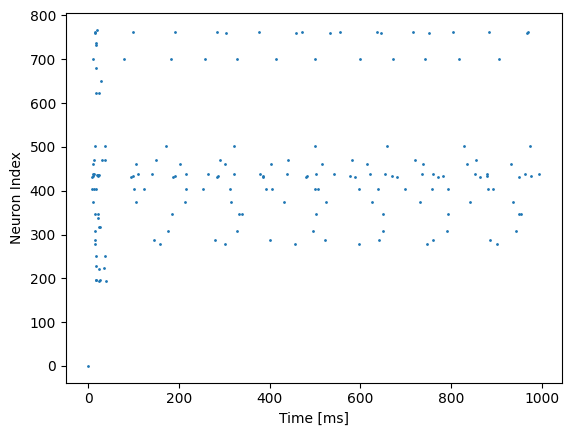

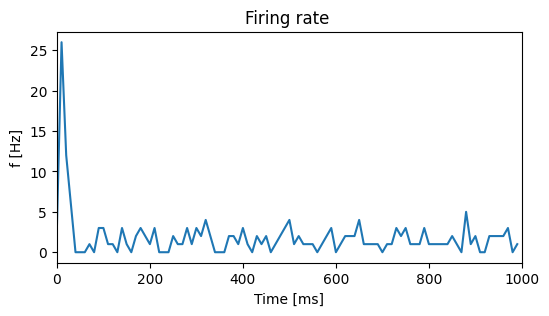

In [45]:
image_paths = [f"{img_dir}/05_lowlight/output.png", 
               f"{img_dir}/05_lowlight/output1.png", 
               f"{img_dir}/05_lowlight/output2.png"]

for image_path in image_paths:
    display(Image(filename=image_path))

### **Irregular Input**

Inputs with an intensity that does not seem to follow a pattern are not able to provide a significant stimulus that allows the network to continue firing meaningfully over time

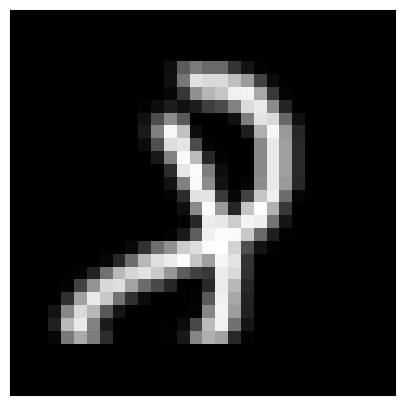

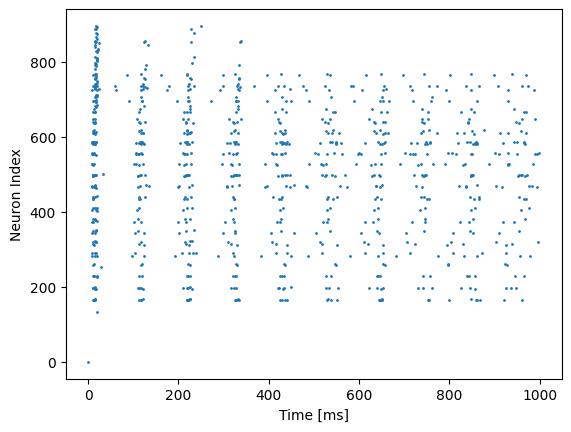

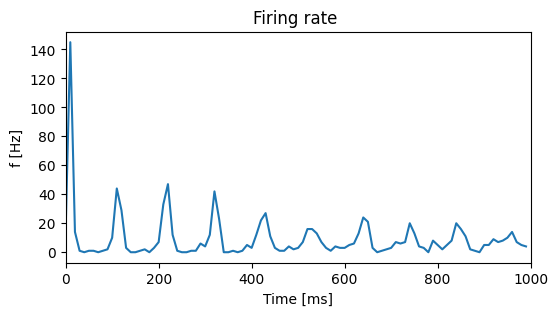

In [46]:
image_paths = [f"{img_dir}/07_irregularlight/output.png", 
               f"{img_dir}/07_irregularlight/output1.png", 
               f"{img_dir}/07_irregularlight/output2.png"]

for image_path in image_paths:
    display(Image(filename=image_path))

### **High Intensity**

A sufficiently strong "balanced" input causes nitid synchronous firing

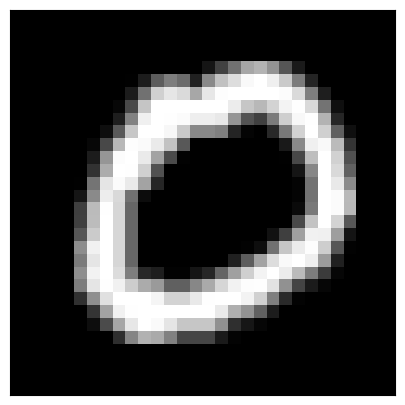

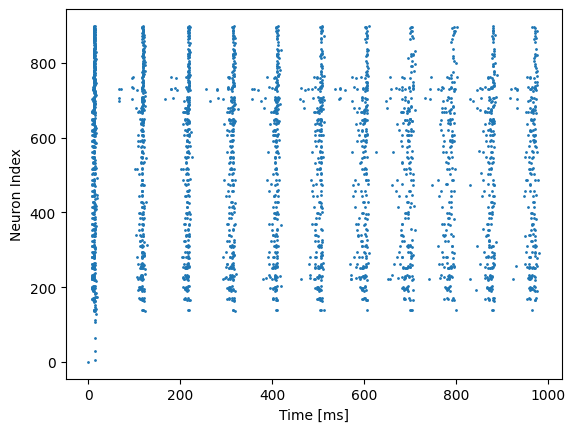

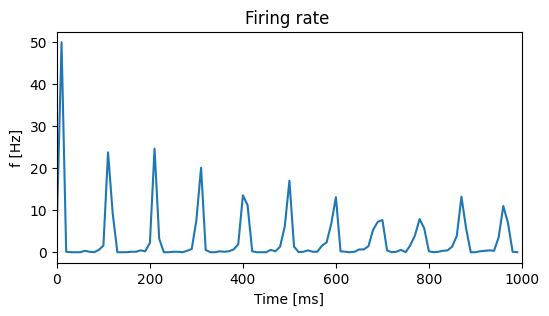

In [47]:
image_paths = [f"{img_dir}/04_brightregular/output.png", 
               f"{img_dir}/04_brightregular/output1.png", 
               f"{img_dir}/04_brightregular/output2.png"]

for image_path in image_paths:
    display(Image(filename=image_path))

## **Classifier Analysis**

- Using as a base the outputs that the model provided us in the previous section, we built up a dataset, which was then preprocessed and fed to an LSTM: this really simple classifier was able to find a __correlation__ between the sequences of neurons' spikes and the labels of the images, correctly matching the two the majority of the time. 
- The performance of this deep neural networks gives us an insight about the capabilities of the Izhikevich model, showing that its responses are actually __meaningful__, __diverse__ and __label-specific__, and also shows us that with more data and/or a more complex model, it could be possible to __decode neural responses__ to more complex inputs.

## **GENERATE DATA & TRAIN DNN**  

### **Model (Multiple Instances)**

In [48]:
def simulate(img, label):
    # Preprocess images
    current = preprocess(img)
    # Initialize neuron parameters (excitatory and inhibitory)
    Ne, Ni, a, b, c, d, S, Ne_size, Ni_size = initialize_neurons(img_size, current)

    # Initialize membrane potentials and recovery variables
    v = -65 * np.ones((Ne_size + Ni_size, 1))  # Membrane potentials
    u = b * v  # Recovery variables

    # Initialize array to store spike times
    spike_times = np.empty((0, 2), dtype=int)

    # Run simulation over the specified time span
    for t in range(time_span):
        
        I = np.concatenate((5 * Ne.reshape(-1, 1),
                            2 * Ni.reshape(-1, 1)), axis=0)

        # Identify neurons that have fired (membrane potential >= threshold)
        fired = np.where(v >= thr)[0]

        if fired.size > 0:
            # Record the spike times for the fired neurons
            firing = np.concatenate((t * np.ones((len(fired), 1)), fired.reshape(-1, 1)), axis=1)
            spike_times = np.concatenate((spike_times, firing), axis=0)

            # Reset the membrane potential and update the recovery variables for the fired neurons
            v[fired] = c[fired]
            u[fired] += d[fired]

            # Add synaptic inputs from other neurons
            I += S[:, fired].sum(axis=1).reshape(-1, 1)

        # Update the membrane potential and recovery variables using the Izhikevich model
        dv = 0.04 * v**2 + 5 * v + 140 - u + I
        v += dv  # First update of the membrane potential
        v += dv  # Apply a second update (as per the original logic)
        u += a * (b * v - u)  # Update the recovery variables

    # Return the spike times and image label
    return spike_times.astype(int), label

### **Preprocess Data** 

In [51]:
def preprocess_spike_data(all_images, all_labels, simulate, img_size, num_images, time_bins, time_range):
    """
    Preprocess spike-time data for LSTM training.

    Parameters:
    - all_images: List or array of input images.
    - all_labels: List or array of corresponding labels.
    - simulate: Function to generate spike times from an image and label.
    - img_size: Size of the input image (assumes square images).
    - num_images: Total number of images.
    - time_bins: Number of time bins.
    - time_range: Tuple indicating the start and end of the time range (ms).

    Returns:
    - lstm_input: 3D array of shape (num_images, time_bins, num_neurons) for LSTM input.
    - labels: Array of corresponding labels.
    """
    # Define parameters
    bin_size = (time_range[1] - time_range[0]) / time_bins
    num_neurons = img_size * img_size
    spike_matrix = np.zeros((num_images, num_neurons, time_bins))  # Initialize spike matrix
    labels = []

    for idx in range(num_images):
        img = all_images[idx]
        label = all_labels[idx]

        # Generate spike times for the current image
        spike_times, label = simulate(img, label)

        # Populate spike matrix with spike counts
        for spike_time, neuron_id in spike_times:
            bin_index = int((spike_time - time_range[0]) / bin_size)
            if 0 <= bin_index < time_bins:
                spike_matrix[idx, neuron_id, bin_index] += 1  # Count spikes

        labels.append(label)

    # Reshape for LSTM: (batch_size, time_bins, num_neurons)
    lstm_input = spike_matrix.transpose(0, 2, 1)

    return lstm_input, np.array(labels)

time_range = (0, 1000)
time_bins = 100

# Preprocess data
lstm_input, labels = preprocess_spike_data(all_images, all_labels, simulate, img_size, num_images, time_bins, time_range)

# Verify output
print("LSTM Input Shape:", lstm_input.shape)  # (num_images, time_bins, num_neurons)
print("Labels Shape:", labels.shape)          # (num_images,)

/tmp/ipykernel_16470/628966199.py:36: RuntimeWarning: overflow encountered in square
  dv = 0.04 * v**2 + 5 * v + 140 - u + I
/tmp/ipykernel_16470/628966199.py:39: RuntimeWarning: invalid value encountered in add
  u += a * (b * v - u)  # Update the recovery variables
/tmp/ipykernel_16470/628966199.py:36: RuntimeWarning: invalid value encountered in add
  dv = 0.04 * v**2 + 5 * v + 140 - u + I


LSTM Input Shape: (10000, 100, 400)
Labels Shape: (10000,)


### **Train Deep Learning Model**

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Parameters
hidden_size = 128 # Number of LSTM hidden units
num_classes = 10  # Number of classes (digits 0-9)
dropout_rate = 0.2
learning_rate = 0.001
batch_size = 32
num_epochs = 30

X_train, X_test, y_train, y_test = train_test_split(lstm_input, labels, test_size=0.2, random_state=42, stratify=labels)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (8000, 100, 400)
Testing Data Shape: (2000, 100, 400)


In [58]:
# Define the Model
model = Sequential([
    LSTM(hidden_size, input_shape=(time_bins, img_size**2), return_sequences=False),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)

/home/capitan/Downloads/generate/venv/lib64/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3223 - loss: 1.9193
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5706 - loss: 1.2919
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6303 - loss: 1.1369
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6605 - loss: 1.0337
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6805 - loss: 0.9863
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6761 - loss: 0.9976
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6956 - loss: 0.9216
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7040 - loss: 0.8975
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7024 - loss: 0.9355
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7357 - loss: 0.7996
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7531 - loss: 0.7647
Epoch 12/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 

### **Evaluation & Analysis**

In [59]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7927 - loss: 1.0297
Test Loss: 1.0053
Test Accuracy: 79.20%


In [60]:
import seaborn as sns

# Select Samples
num_samples = len(X_test)
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Prepare the input data (spike data) and true labels
sample_images = X_test[sample_indices]
true_labels = y_test[sample_indices]

# Predict the labels from the encoded rates using the trained model
predicted_labels = model.predict(sample_images)

# Convert predictions to class labels (not probabilities)
predicted_labels = np.argmax(predicted_labels, axis=1)

for i in range(num_samples):
    print(f"Sample {i+1}: GT: {true_labels[i]}, Pred: {predicted_labels[i]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Sample 1: GT: 3, Pred: 2
Sample 2: GT: 9, Pred: 4
Sample 3: GT: 0, Pred: 0
Sample 4: GT: 9, Pred: 9
Sample 5: GT: 7, Pred: 3
Sample 6: GT: 5, Pred: 2
Sample 7: GT: 9, Pred: 9
Sample 8: GT: 0, Pred: 0
Sample 9: GT: 1, Pred: 1
Sample 10: GT: 2, Pred: 2
Sample 11: GT: 3, Pred: 3
Sample 12: GT: 7, Pred: 7
Sample 13: GT: 0, Pred: 0
Sample 14: GT: 7, Pred: 7
Sample 15: GT: 3, Pred: 3
Sample 16: GT: 9, Pred: 9
Sample 17: GT: 5, Pred: 5
Sample 18: GT: 2, Pred: 2
Sample 19: GT: 3, Pred: 3
Sample 20: GT: 4, Pred: 9
Sample 21: GT: 1, Pred: 1
Sample 22: GT: 2, Pred: 2
Sample 23: GT: 7, Pred: 7
Sample 24: GT: 4, Pred: 4
Sample 25: GT: 3, Pred: 3
Sample 26: GT: 9, Pred: 7
Sample 27: GT: 4, Pred: 9
Sample 28: GT: 9, Pred: 9
Sample 29: GT: 3, Pred: 3
Sample 30: GT: 2, Pred: 2
Sample 31: GT: 4, Pred: 4
Sample 32: GT: 0, Pred: 0
Sample 33: GT: 5, Pred: 5
Sample 34: GT: 6, Pred: 2
Sample 35: GT: 3, Pred: 8
Sample 36: GT: 9, Pred: 9
Sample 37: GT: 4, Pred: 4
Sample 

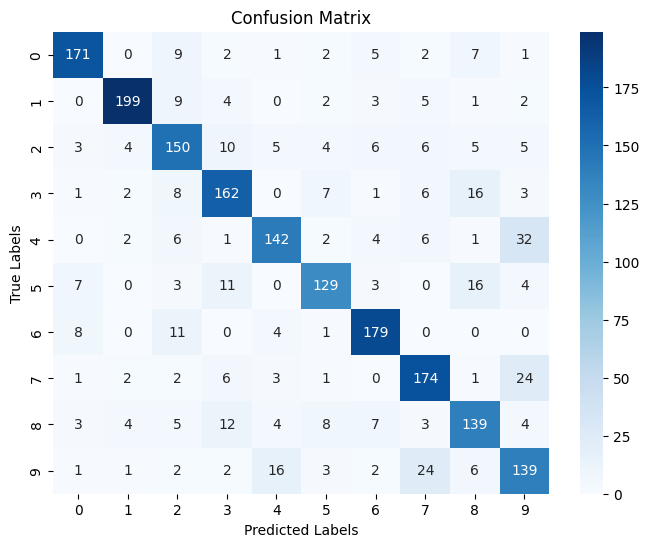

In [61]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
